In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import torch.nn.functional as F

In [2]:
papers = pd.read_csv("data/sci_papers.csv")


In [3]:
papers.head()

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


In [4]:
papers.shape, papers.columns, papers.dtypes, papers.describe()

((136238, 10),
 Index(['id', 'title', 'category', 'category_code', 'published_date',
        'updated_date', 'authors', 'first_author', 'summary',
        'summary_word_count'],
       dtype='object'),
 id                    object
 title                 object
 category              object
 category_code         object
 published_date        object
 updated_date          object
 authors               object
 first_author          object
 summary               object
 summary_word_count     int64
 dtype: object,
        summary_word_count
 count       136238.000000
 mean           162.386830
 std             49.374474
 min              1.000000
 25%            128.000000
 50%            160.000000
 75%            195.000000
 max            552.000000)

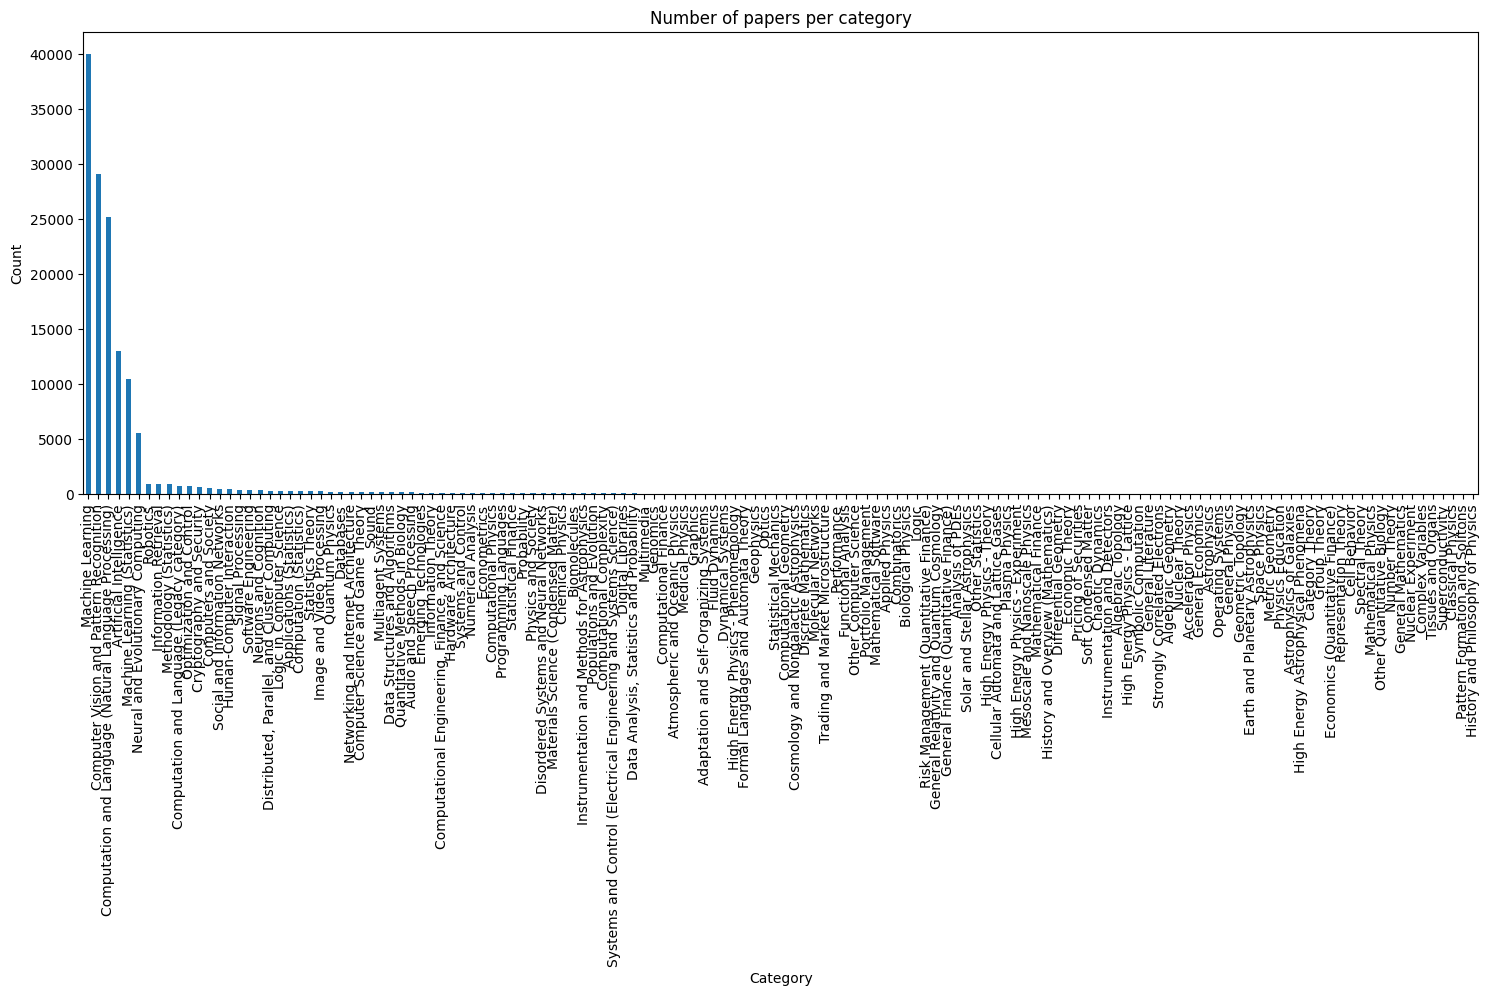

In [5]:
counts = papers["category"].value_counts()
plt.figure(figsize=(12,6))
counts.plot(kind='bar')
plt.gcf().set_size_inches(18, 6)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of papers per category')
plt.xticks(rotation=90)
plt.show()


In [6]:
print(counts[:10])
# We see a quick drop after "Neural and Evolutionary Computing" 

category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
Neural and Evolutionary Computing                          5509
Robotics                                                    903
Information Retrieval                                       901
Methodology (Statistics)                                    882
Computation and Language (Legacy category)                  750
Name: count, dtype: int64


### Dataset Creation 

X : title of the paper

y : category of the paper

Goal : To classify the papers into different categories based on the title of the paper.

There is a total of 18577 papers that are not in the first 5 main categories
and there are 117661 papers in the first 6 categories

 category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
others                                                    18577
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
Name: count, dtype: int64


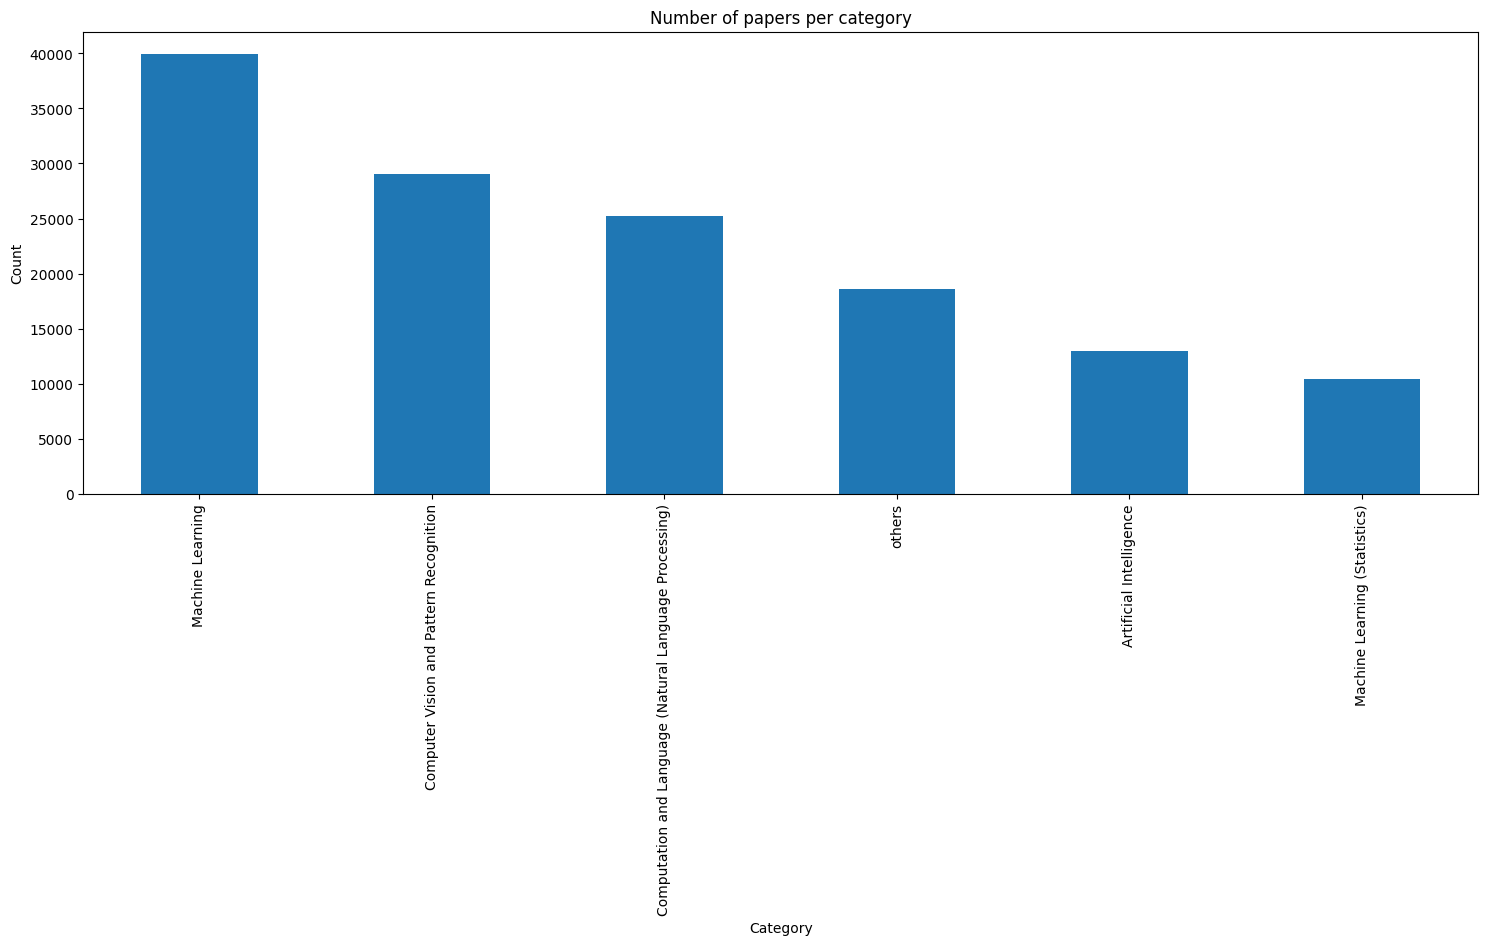

In [7]:
# First, because of the under representation of many categories, I will create an "others" category
# It will contain all categories except the first 5 most populated ones 
# i.e "Machine Learning", "Computer Vision", "computation and langage (...)","Information Retrieval", "Natural Language Processing"

df = papers
categories = df.category.unique()
others = counts.index[5:].tolist()


# Modification of the values in "category"
df.loc[df['category'].isin(others), 'category'] = 'others'
print("There is a total of %d papers that are not in the first 5 main categories" % ((df['category'] == 'others').sum()))
print("and there are %d papers in the first 6 categories" % ((df['category'] != 'others').sum()))

print("\n", df.category.value_counts())

# Now, the distribution is more balanced
plt.figure(figsize=(12,6))
df.category.value_counts().plot(kind='bar')
plt.gcf().set_size_inches(18, 6)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of papers per category')
plt.xticks(rotation=90)
plt.show()


In [8]:
# First we wan't a mapping from int to title and a mapping from category to int and vice versa

titles = [s.replace('\n', '').strip() for s in df.title.tolist()]
categories = df.category.unique()

ttoi = {t:i for i,t in enumerate(titles)} # title to integer 
itot = {i:t for i,t in enumerate(titles)} # integer to title

ctoi = {c:i for i,c in enumerate(categories)} # category to integer
itoc = {i:c for i,c in enumerate(categories)} # integer to category

itoc


{0: 'Artificial Intelligence',
 1: 'others',
 2: 'Machine Learning',
 3: 'Computation and Language (Natural Language Processing)',
 4: 'Computer Vision and Pattern Recognition',
 5: 'Machine Learning (Statistics)'}

In [9]:
nrows = 1000 # we won't work with the entire csv file now 
X = torch.arange(0, nrows)
Y = torch.tensor([ctoi[df["category"][i]] for i in range(0, X[-1].item())])

print(Y[:5])
print(itoc[0])
# X is the list of the indexes of the titles 
# Y is the list of all the indexes of the categories

tensor([0, 0, 0, 0, 0])
Artificial Intelligence


In [26]:
def build_dataset(papers):  
    X = torch.arange(0, papers.shape[0])
    Y = torch.tensor([ctoi[df["category"][i]] for i in range(0, papers.shape[0])])
    #print(X.shape, Y.shape)
    return X, Y

build_dataset(df[:10])

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
import random
random.seed(42)
indices = list(range(len(papers)))
random.shuffle(indices)
papers_shuffled = papers.iloc[indices].reset_index(drop=True) # shuffled dataset 
n1 = int(0.8*len(papers_shuffled))
n2 = int(0.9*len(papers_shuffled))
Xtr, Ytr = build_dataset(papers_shuffled[:n1])
Xdev, Ydev = build_dataset(papers_shuffled[n1:n2])
Xte, Yte = build_dataset(papers_shuffled[n2:])

### Model Creation 

I'm going to create an MLP from scratch using pytorch. 

First, let's try to embbed at the title level. 

Then, we will try to embed at the word level.

In [28]:
# First we need to embed our titles 
emb_dim = 50 # we've got 136238 differents titles that we need to represente in a much smaller space 

C = torch.randn((df.shape[0], emb_dim))
print(C.shape)
print("coordinates of the first title : ", C[0])
print("The title is : ", itot[0])

torch.Size([136238, 50])
coordinates of the first title :  tensor([ 0.7028,  1.1653,  1.1876,  0.7735, -0.5598, -0.1511, -1.4673,  0.6471,
        -0.2363, -0.9965, -0.9315, -0.1337, -0.0413,  0.0400, -0.5642,  0.5929,
         1.9954,  1.5194,  1.6367, -1.1407, -2.1364,  1.8401, -0.0613, -1.4273,
         0.2456, -1.2441, -0.9125,  0.7793, -0.2571,  1.6086, -1.1912,  0.5887,
         0.0468,  0.6695,  0.2717, -0.6879,  1.0410, -1.1258,  0.0178, -0.8789,
         0.7405,  2.7237, -2.8142, -1.0381,  0.1121, -2.2019, -1.0478, -1.0155,
        -1.6675,  0.2511])
The title is :  Dynamic Backtracking


In [29]:
emb = C[X]
emb.shape

torch.Size([1000, 50])

In [137]:
nbr_added_layers = 1
nbr_neurons_hidden = [256 for _ in range(nbr_added_layers)]
nbr_neurons_first = 512
nbr_categories = len(categories)
emb_dim = 50

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((Xtr.shape[0], emb_dim), generator=g)
W1 = torch.randn((emb_dim, nbr_neurons_first), generator=g) / nbr_neurons_first**0.5 # kaiming init
b1 = torch.randn(nbr_neurons_first, generator=g) * 0.1

Ws = []
bs = []
parameters = [C, W1, b1]
for i in range(0, nbr_added_layers):
    if i == 0:
        W = torch.randn((nbr_neurons_first, nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    else : 
        W = torch.randn((nbr_neurons_hidden[i], nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    
    b = torch.randn(nbr_neurons_hidden[i], generator=g) * 0.1
    parameters.append(W)
    parameters.append(b)
    Ws.append(W)
    bs.append(b)

Wlast = torch.randn((nbr_neurons_hidden[-1], nbr_categories), generator=g) / nbr_neurons_hidden[-1]**0.5
blast = torch.randn((nbr_categories), generator=g) * 0.1

parameters.append(Wlast)
parameters.append(blast)

for p in parameters:
    print(p.shape)

print(sum(p.nelement() for p in parameters))

torch.Size([108990, 50])
torch.Size([50, 512])
torch.Size([512])
torch.Size([512, 256])
torch.Size([256])
torch.Size([256, 6])
torch.Size([6])
5608482


In [138]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, lri = [], [], []

In [140]:
n = 1*10**4
batch_size = 100
lre = torch.linspace(-3, 0, n)
lrs = 10**lre #from 0.001 to 1 exponentielly stepped 

for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[ixs] 
    x = torch.tanh(emb @ W1 + b1) 

    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)

    
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Use modulo to cycle through learning rates
    lr = lrs[i % len(lrs)]
    for p in parameters:
        p.data += -lr * p.grad 

    stepi.append(i)
    lri.append(lr.item())
    lossi.append(loss.item())


In [141]:
def deep_model_test(X,Y):
    emb = C[X] 
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Y) 

    return loss

ldev = deep_model_test(Xdev, Ydev)
ltest = deep_model_test(Xte, Yte)
ltrain = deep_model_test(Xtr, Ytr)
print("ltrain : ", ltrain)
print("dev : ", ldev)
print("test : ", ltest)

ltrain :  tensor(1.6155, grad_fn=<NllLossBackward0>)
dev :  tensor(2.1956, grad_fn=<NllLossBackward0>)
test :  tensor(2.1956, grad_fn=<NllLossBackward0>)


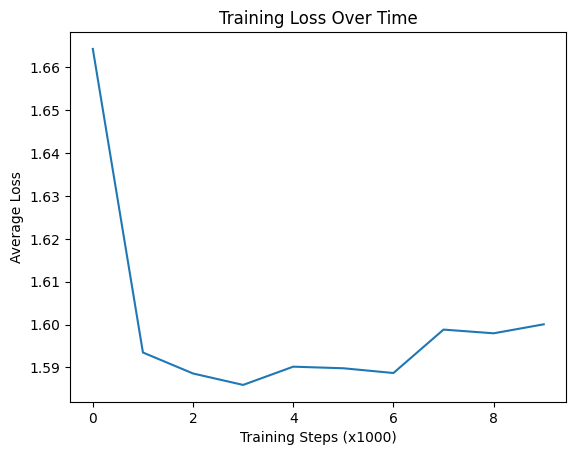

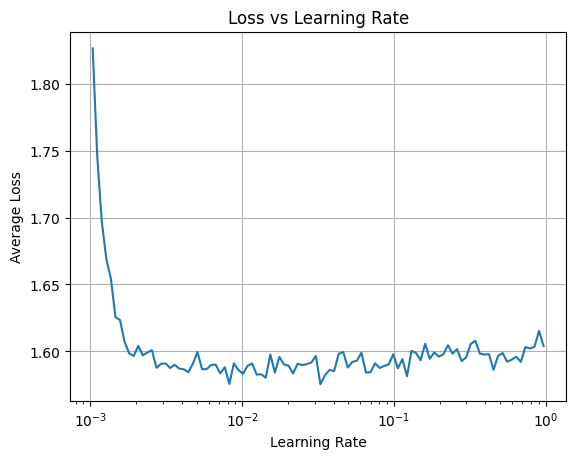

In [161]:
# Plot 1: Loss over training iterations (averaged over 1000 iterations)
plt.figure()
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.xlabel('Training Steps (x1000)')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.show()

# Plot 2: Loss vs Learning Rate (averaged over 100 iterations)
plt.figure()
plt.plot(torch.tensor(lri).view(-1, 100).mean(1), torch.tensor(lossi).view(-1, 100).mean(1))
plt.xlabel('Learning Rate')
plt.ylabel('Average Loss')
plt.title('Loss vs Learning Rate')
plt.xscale('log')  # Learning rate is typically better viewed in log scale
plt.grid(True)
plt.show()

In [129]:
# let's display some results 

# forward
emb = C[Xte] 
x = torch.tanh(emb @ W1 + b1)  
for W, b in zip(Ws, bs): 
    x = torch.tanh(x @ W + b)
logits = x @ Wlast + blast
probs = F.softmax(logits, dim=1)

# Display last 5 results
print("5 papers predictions:")
indices = torch.randint(0, len(papers_shuffled.iloc[n2:]), (5,))
for idx in indices:
    print("\nTitle:", papers_shuffled.iloc[n2:].iloc[idx.item()]['title'])
    print("True category:", papers_shuffled.iloc[n2:].iloc[idx.item()]['category'])
    print("\nPredicted probabilities:")
    # Sort probabilities in descending order and get corresponding categories
    sorted_probs = [(prob.item(), cat) for prob, cat in zip(probs[idx.item()], categories)]
    sorted_probs.sort(reverse=True)
    for prob, cat in sorted_probs:
        print(f"{cat}: {prob*100:.2f}%")




5 papers predictions:

Title: Mimicking Word Embeddings using Subword RNNs
True category: Computation and Language (Natural Language Processing)

Predicted probabilities:
Machine Learning: 72.08%
Artificial Intelligence: 14.72%
Computer Vision and Pattern Recognition: 9.52%
others: 1.51%
Computation and Language (Natural Language Processing): 1.23%
Machine Learning (Statistics): 0.94%

Title: Multi-Agent Systems based on Contextual Defeasible Logic considering
  Focus
True category: Artificial Intelligence

Predicted probabilities:
Machine Learning: 73.43%
Artificial Intelligence: 15.23%
Computer Vision and Pattern Recognition: 6.66%
others: 2.34%
Machine Learning (Statistics): 1.97%
Computation and Language (Natural Language Processing): 0.36%

Title: How green is continual learning, really? Analyzing the energy
  consumption in continual training of vision foundation models
True category: Machine Learning

Predicted probabilities:
Artificial Intelligence: 50.31%
Computer Vision and P

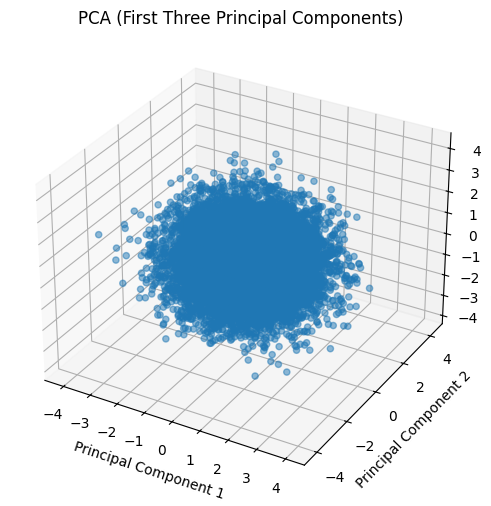

Composante 1: 1.17%
Composante 2: 1.16%
Composante 3: 1.16%
Composante 4: 1.16%
Composante 5: 1.15%
Composante 6: 1.14%
Composante 7: 1.14%
Composante 8: 1.14%
Composante 9: 1.12%
Composante 10: 1.12%


In [118]:
# We'll perform PCA by hand on the 'emb' tensor.
# 1. Detach the tensor and center the data
X = emb.detach()
X_centered = X - X.mean(dim=0)

# 2. Compute the covariance matrix (using Bessel's correction)
cov = (X_centered.t() @ X_centered) / (X_centered.shape[0] - 1)

# 3. Compute the eigenvalues and eigenvectors. Since the covariance matrix is symmetric, we can use torch.linalg.eigh.
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# 4. Sort the eigenvalues (and corresponding eigenvectors) in descending order
sorted_indices = torch.argsort(eigenvalues, descending=True)
top3_eigenvectors = eigenvectors[:, sorted_indices[:3]]

# 5. Project the centered data onto the top 2 eigenvectors (principal components)
proj = X_centered @ top3_eigenvectors

# 6. Plot the first three principal components in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proj[:, 0].numpy(), proj[:, 1].numpy(), proj[:, 2].numpy(), alpha=0.5)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA (First Three Principal Components)")
plt.show()

sorted_eigenvalues = eigenvalues[sorted_indices]
explained_variance_ratio = sorted_eigenvalues[:10] / sorted_eigenvalues.sum()
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Composante {i}: {ratio.item() * 100:.2f}%")


Results for Training Set:
Accuracy: 0.4247


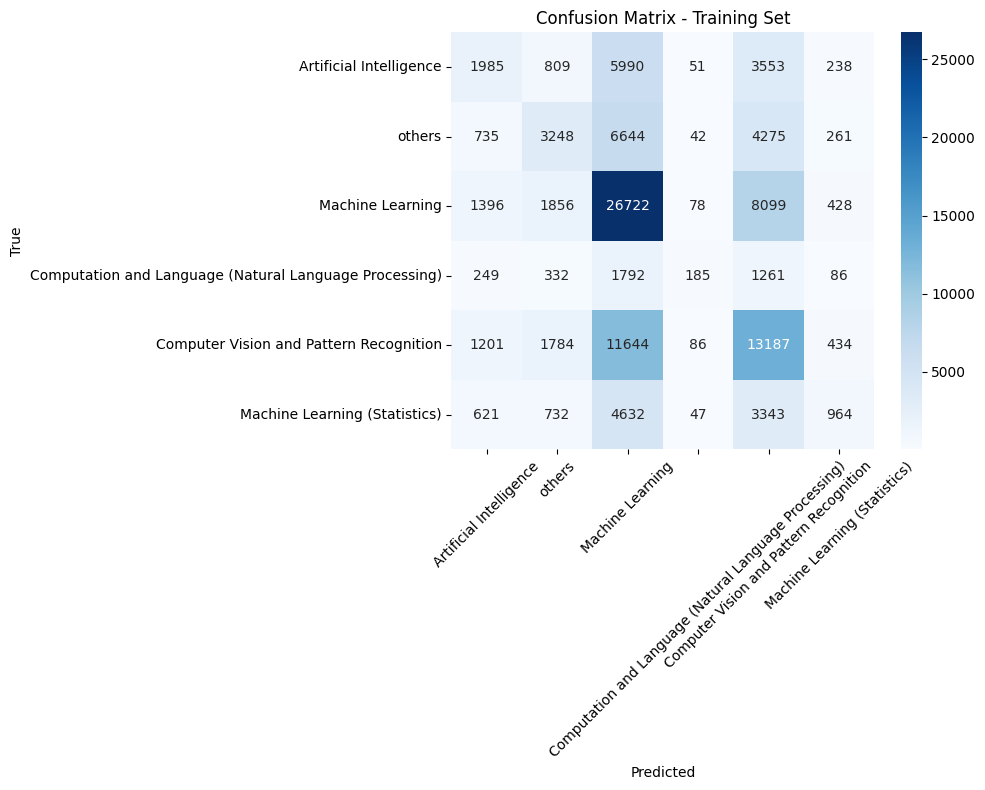


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.32      0.16      0.21     12626
                                                others       0.37      0.21      0.27     15205
                                      Machine Learning       0.47      0.69      0.56     38579
Computation and Language (Natural Language Processing)       0.38      0.05      0.08      3905
               Computer Vision and Pattern Recognition       0.39      0.47      0.43     28336
                         Machine Learning (Statistics)       0.40      0.09      0.15     10339

                                              accuracy                           0.42    108990
                                             macro avg       0.39      0.28      0.28    108990
                                          weighted avg       0.41      0.42      0.39    108990


Results for 

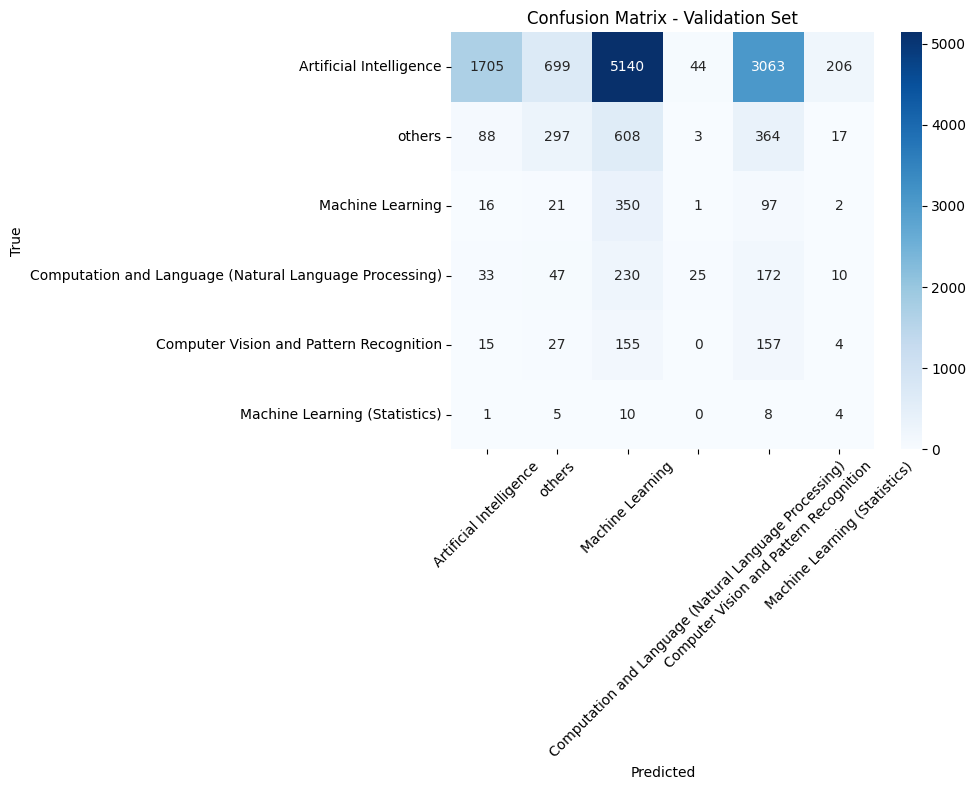


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.92      0.16      0.27     10857
                                                others       0.27      0.22      0.24      1377
                                      Machine Learning       0.05      0.72      0.10       487
Computation and Language (Natural Language Processing)       0.34      0.05      0.08       517
               Computer Vision and Pattern Recognition       0.04      0.44      0.07       358
                         Machine Learning (Statistics)       0.02      0.14      0.03        28

                                              accuracy                           0.19     13624
                                             macro avg       0.27      0.29      0.13     13624
                                          weighted avg       0.77      0.19      0.25     13624


Results for 

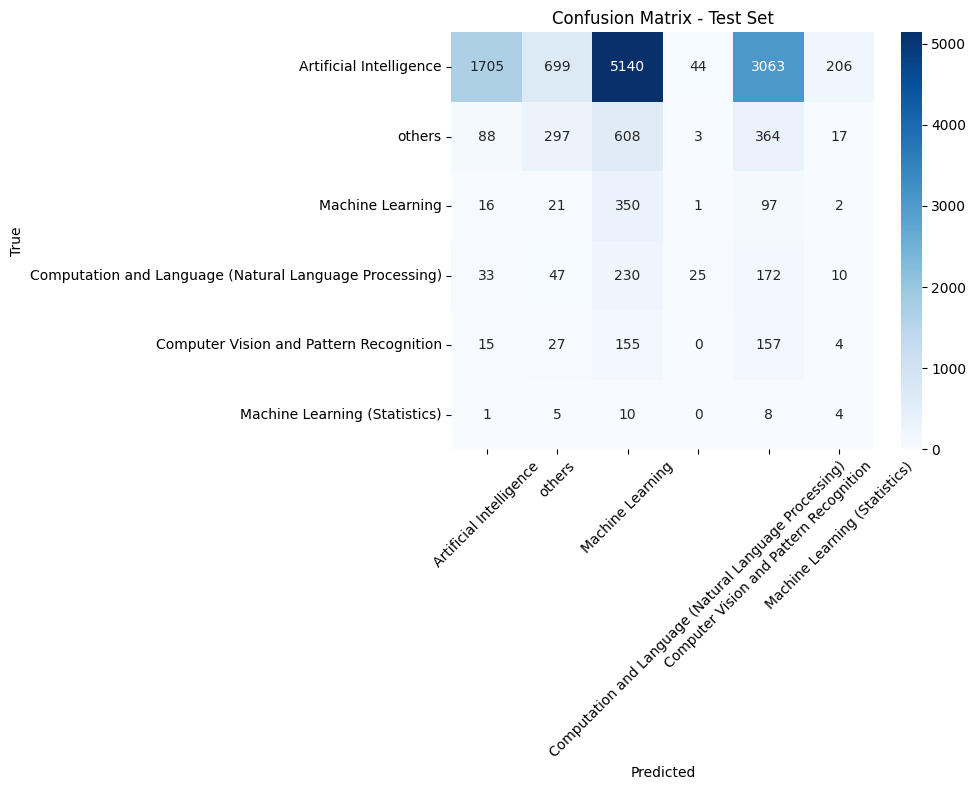


Classification Report:
                                                        precision    recall  f1-score   support

                               Artificial Intelligence       0.92      0.16      0.27     10857
                                                others       0.27      0.22      0.24      1377
                                      Machine Learning       0.05      0.72      0.10       487
Computation and Language (Natural Language Processing)       0.34      0.05      0.08       517
               Computer Vision and Pattern Recognition       0.04      0.44      0.07       358
                         Machine Learning (Statistics)       0.02      0.14      0.03        28

                                              accuracy                           0.19     13624
                                             macro avg       0.27      0.29      0.13     13624
                                          weighted avg       0.77      0.19      0.25     13624



In [119]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Import additional metrics

def evaluate_model(X, Y, split_name=""):
    # Forward pass
    emb = C[X] 
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    probs = F.softmax(logits, dim=1)
    
    # Get predictions
    predictions = torch.argmax(probs, dim=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y.numpy(), predictions.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(Y.numpy(), predictions.numpy())
    
    # Print results
    print(f"\nResults for {split_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[itoc[i] for i in range(len(categories))],
                yticklabels=[itoc[i] for i in range(len(categories))])
    plt.title(f'Confusion Matrix - {split_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y.numpy(), predictions.numpy(), 
                              target_names=[itoc[i] for i in range(len(categories))]))
    
    return accuracy, predictions

# Evaluate on all splits
train_acc, train_preds = evaluate_model(Xtr, Ytr, "Training Set")
val_acc, val_preds = evaluate_model(Xdev, Ydev, "Validation Set")
test_acc, test_preds = evaluate_model(Xte, Yte, "Test Set")

### Conclusions : 

Embedding at the title level is definitely not sufficient.

Best results so far (without really trying) :
- ltrain :  1.1821
- dev : 1.5438
- test : 1.5438

Things to try :
- Embedding at the word level
- Use the abstract of the paper
- Use the abstract of the paper and the title of the paper